<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 05 &mdash; Generated Data**

&copy; Dr. Yves J. Hilpisch

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Simple Example

In [5]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

2025-03-05 21:14:47.167797: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 21:14:47.171811: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 21:14:47.232278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 21:14:48.318969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
x = np.linspace(-2, 2, 500)  # <1>

In [9]:
def f(x):
    return x ** 3  # <2>

In [10]:
y = f(x)  # <3>

In [11]:
scaler = StandardScaler()  # <4>

In [12]:
y_ = scaler.fit_transform(y.reshape(-1, 1))  # <4>

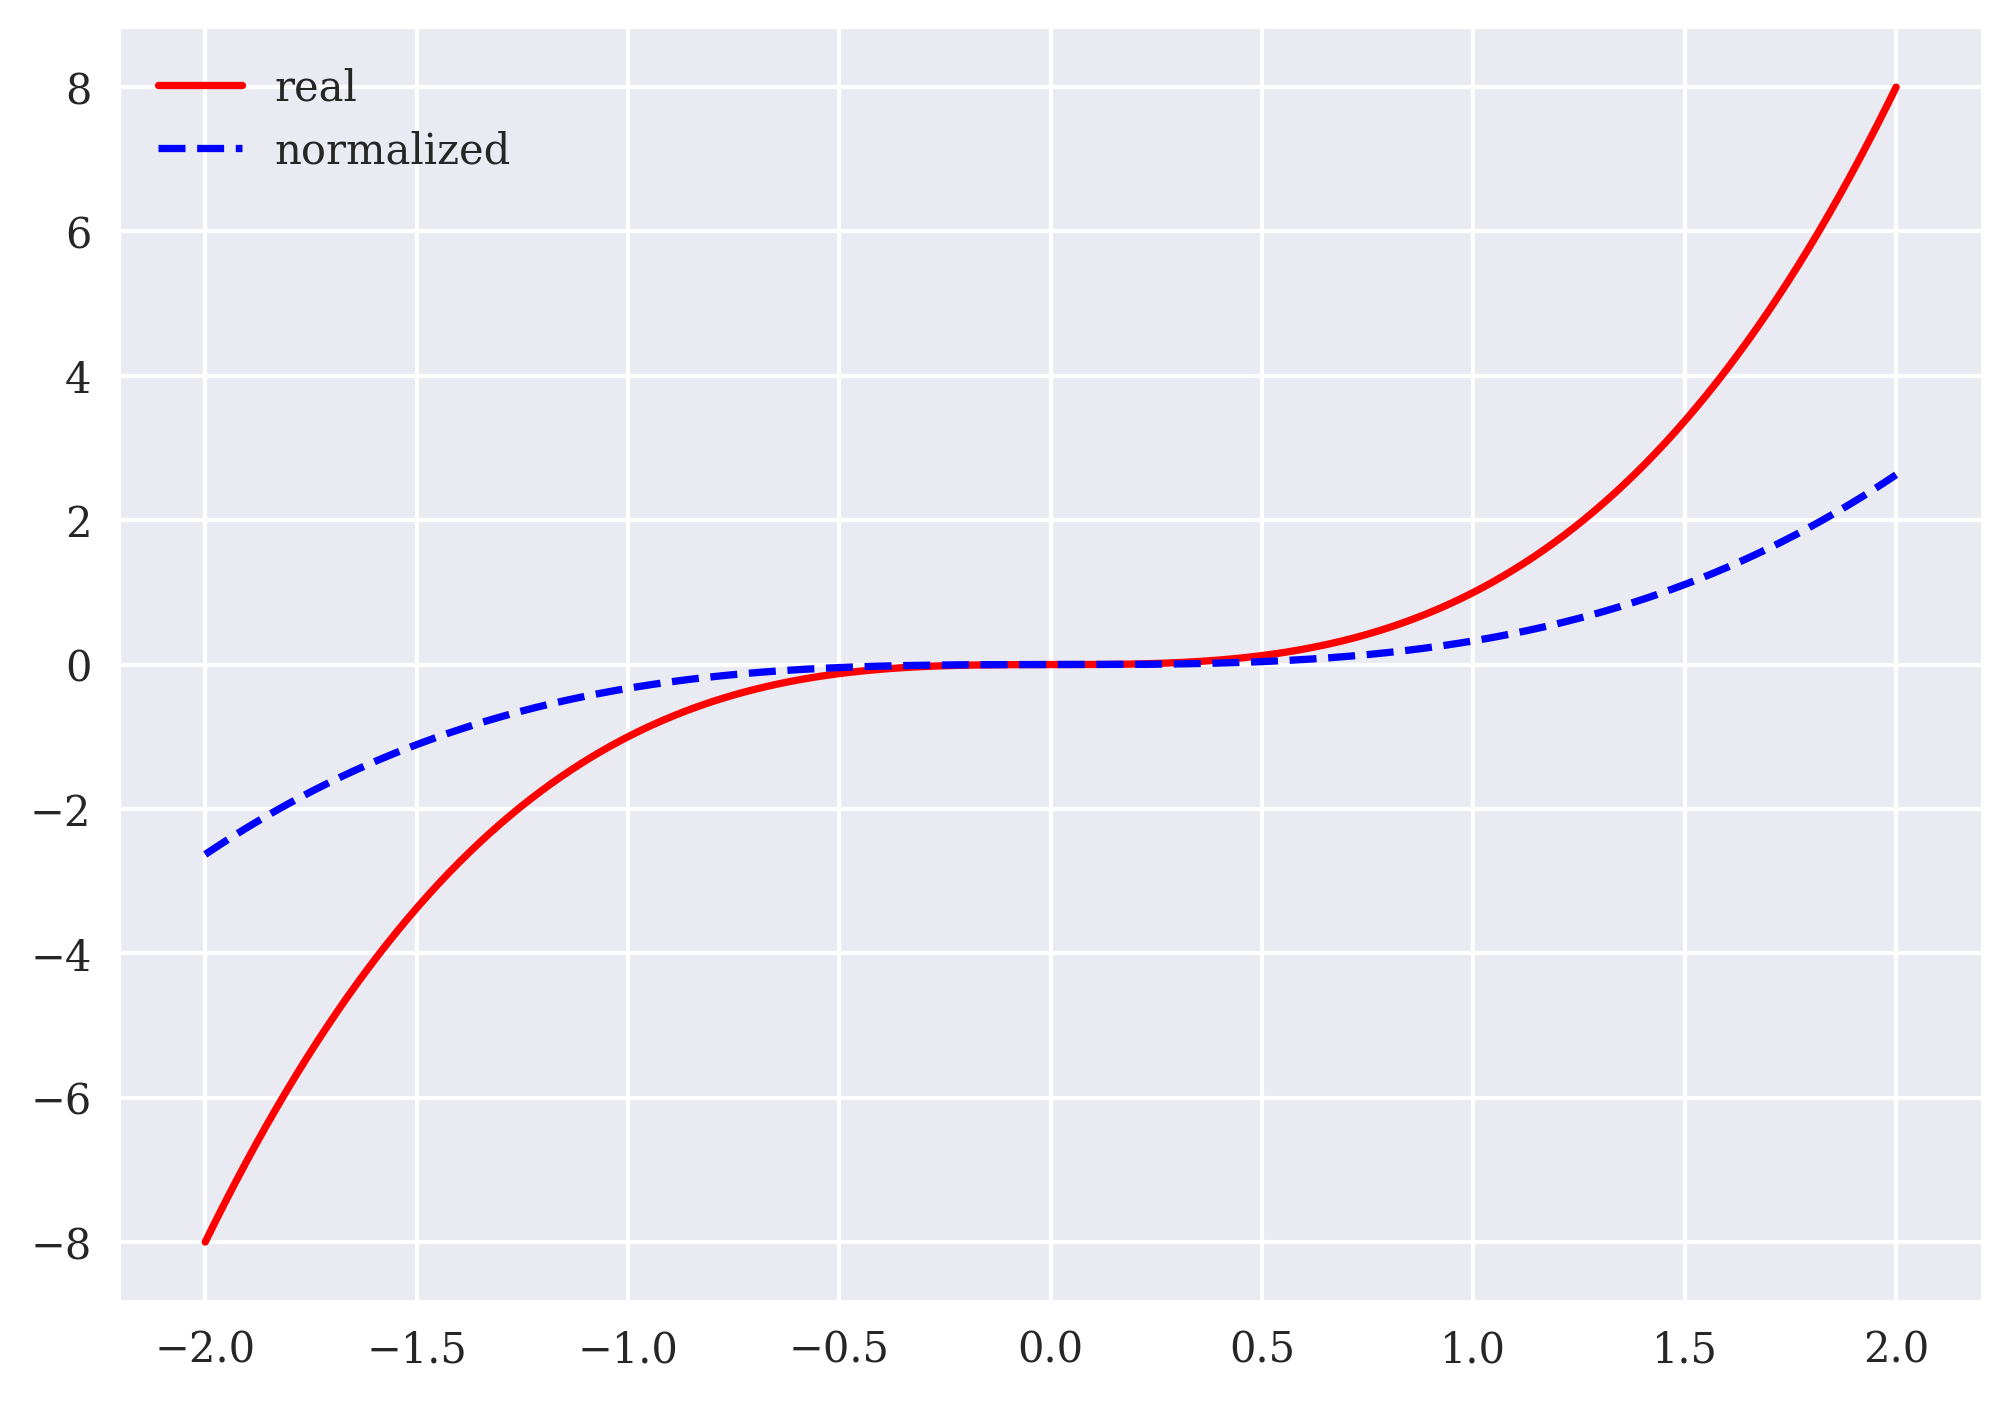

In [13]:
plt.plot(x, y, 'r', label='real')
plt.plot(x, y_, 'b--', label='normalized')
plt.legend();

### Model Training

In [15]:
def create_generator(hu=32):
    model = Sequential()
    model.add(Input(shape=(1, )))
    model.add(Dense(hu, activation='relu')) # , input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # model.compile(loss='binary_crossentropy', optimizer=Adam(),
    #               metrics=['accuracy'])
    return model

In [16]:
def create_discriminator(hu=32):
    model = Sequential()
    model.add(Input(shape=(1,)))
    model.add(Dense(hu, activation='relu')) # , input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [17]:
def create_gan(generator, discriminator, lr=0.001):
    discriminator.trainable = False  # <1>
    model = Sequential()
    model.add(generator)  # <2>
    model.add(discriminator)  # <3>
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr)) # ,metrics=['accuracy'])
    return model

generator = create_generator()  # <4>
discriminator = create_discriminator()  # <4>
gan = create_gan(generator, discriminator, 0.001)  # <4>

In [18]:
from numpy.random import default_rng

In [19]:
rng = default_rng(seed=100)

In [20]:
def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))  # <1>
        synthetic_data = generator.predict(noise, verbose=False)  # <2>

        # Train discriminator
        real_data = y_[rng.integers(0, len(y_), batch_size)]  # <3>
        discriminator.train_on_batch(real_data, np.ones(batch_size))  # <4>
        discriminator.train_on_batch(synthetic_data, np.zeros(batch_size))  # <5>

        # Train GAN
        noise = rng.normal(0, 1, (batch_size, 1))  # <6>
        gan.train_on_batch(noise, np.ones(batch_size))  # <7>

        # Print progress
        if epoch % 200 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

In [21]:
%%time
real_data, synthetic_data = train_models(y_, epochs=1001, batch_size=64)

/home/casper/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
Epoch: 1000
CPU times: user 5min 29s, sys: 3.62 s, total: 5min 33s
Wall time: 5min 30s


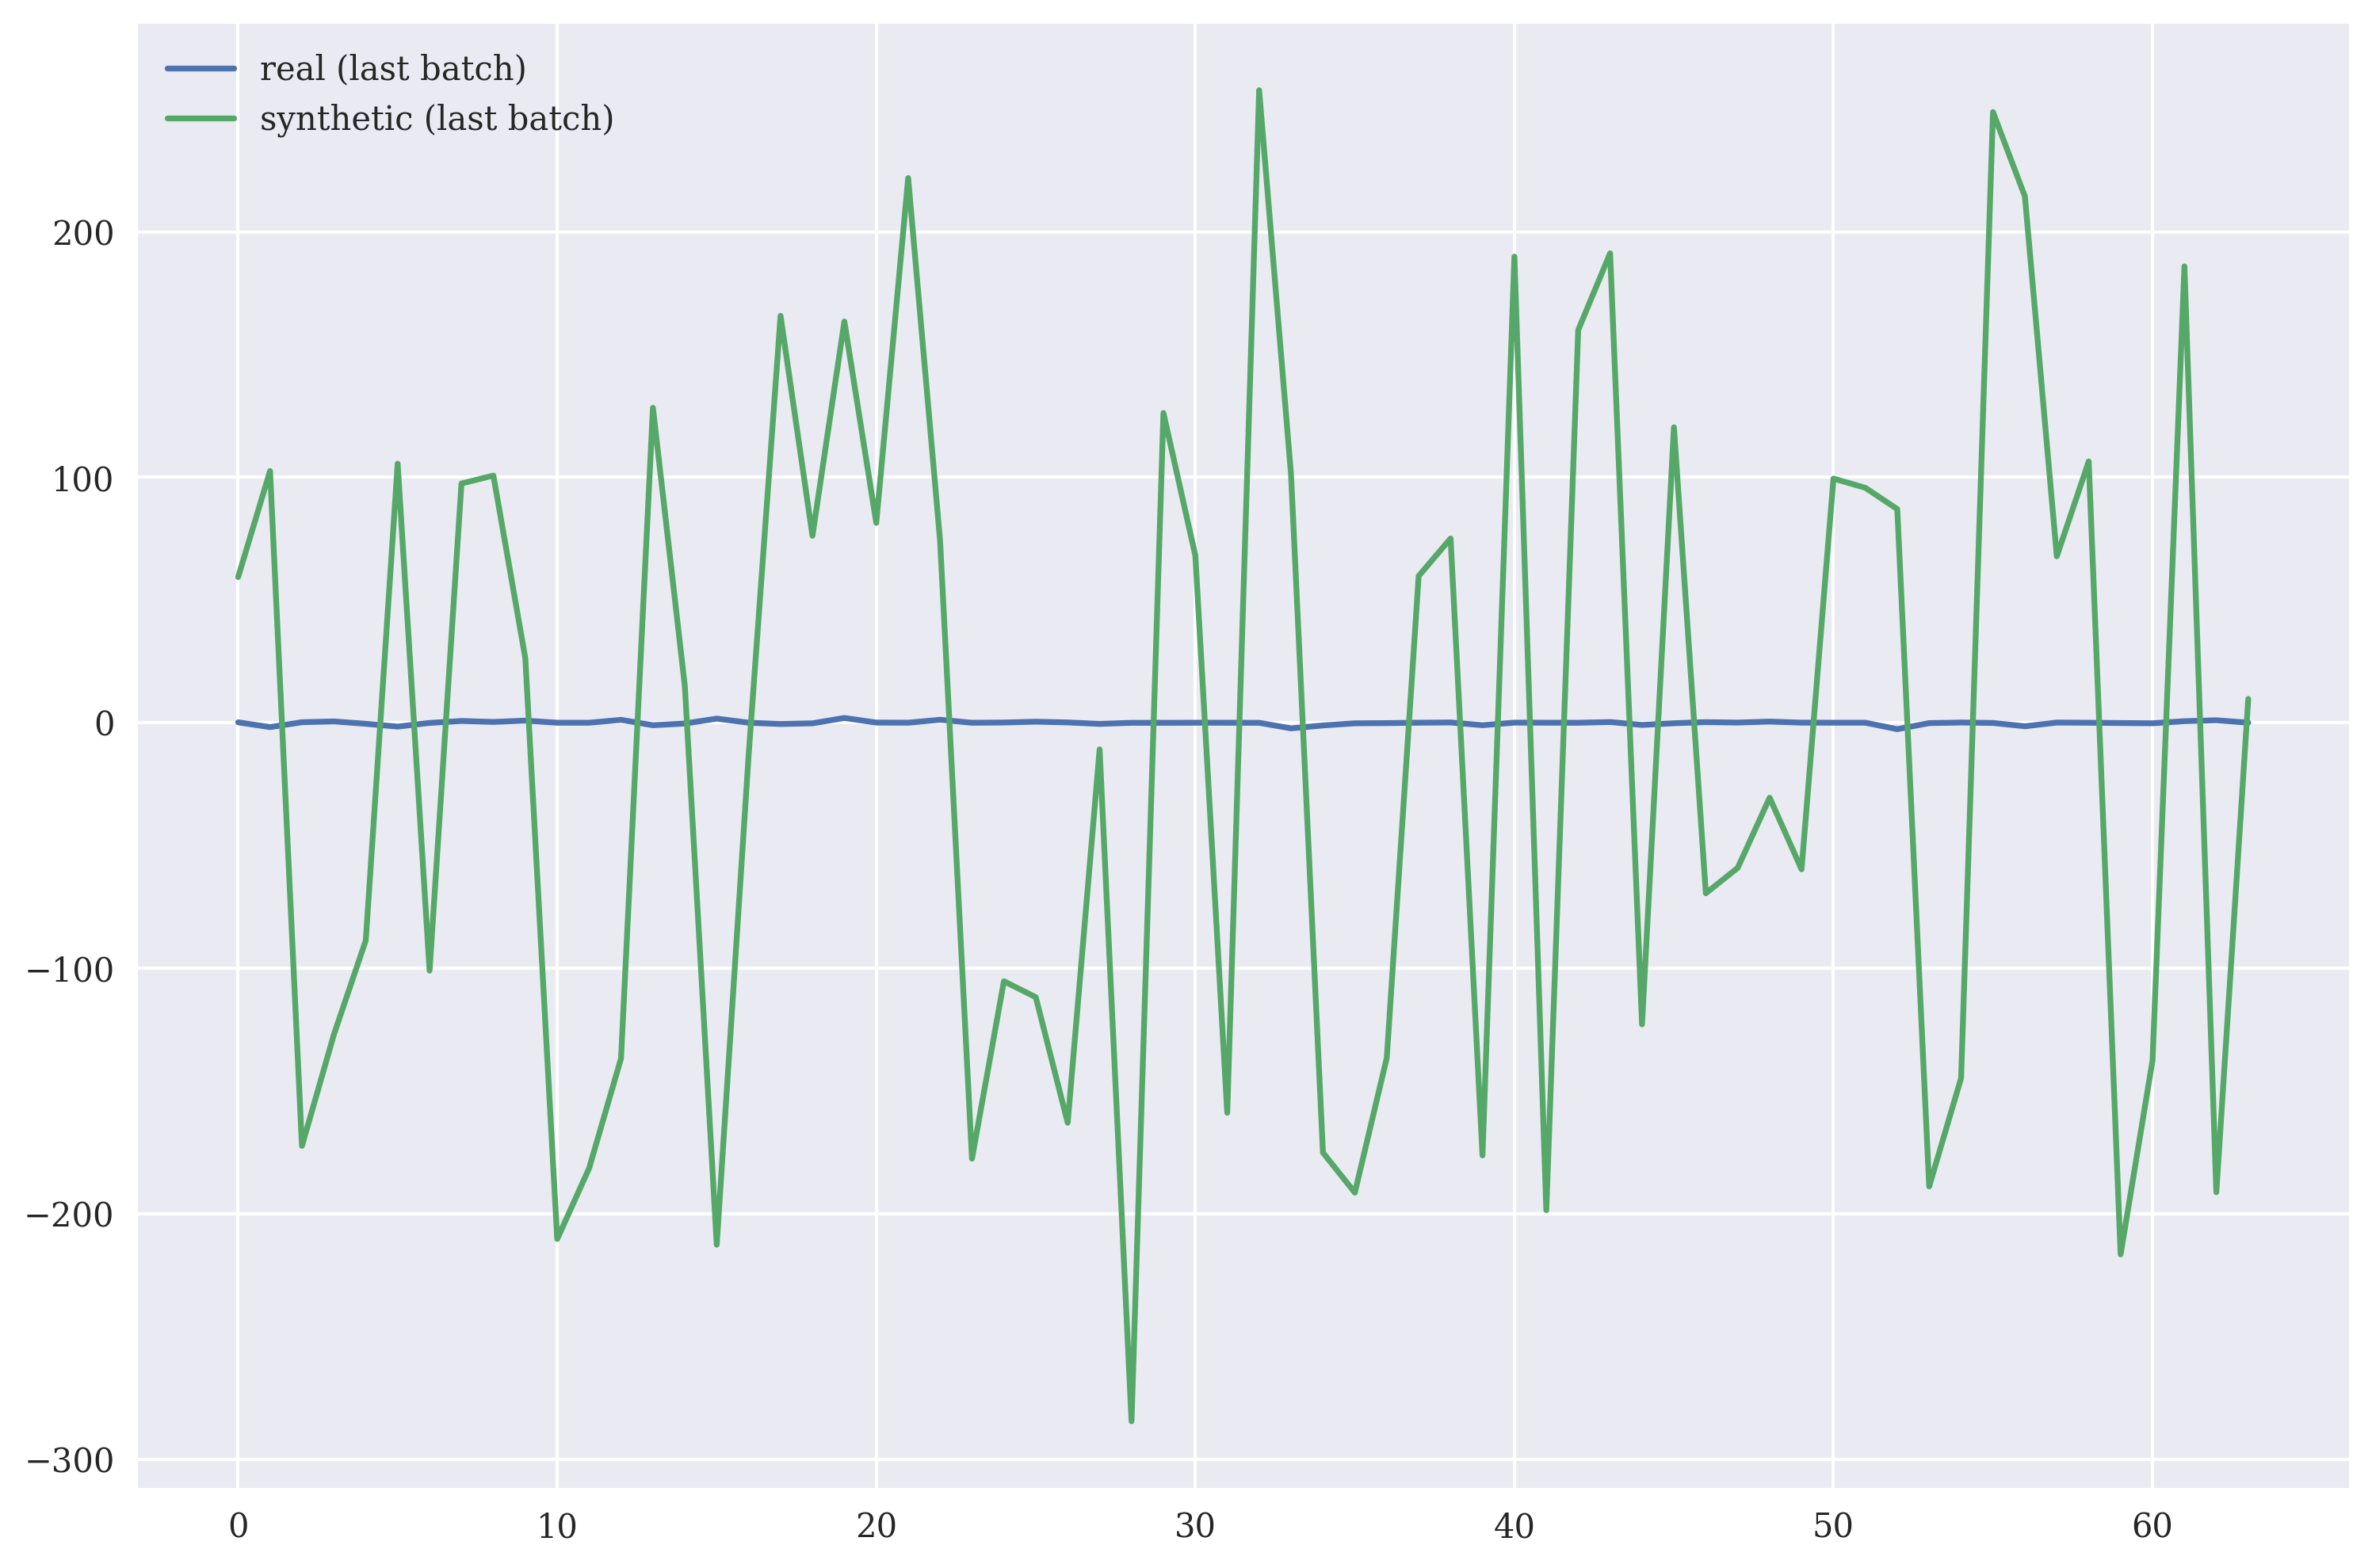

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(real_data, label='real (last batch)')
plt.plot(synthetic_data, label='synthetic (last batch)')
plt.legend();

In [23]:
data = pd.DataFrame({'real': y}, index=x)

In [24]:
N = 5  # <1>
for i in range(N):
    noise = rng.normal(0, 1, (len(y), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [25]:
data.describe().round(3)

,real,synth_00,synth_01,synth_02,synth_03,synth_04
count,500.000,500.000,500.000,500.000,500.000,500.000
mean,-0.000,35.010,27.092,-25.523,22.473,19.841
std,3.045,437.922,472.905,493.251,463.389,489.686
min,-8.000,-1113.754,-1295.919,-1663.507,-1326.589,-1558.660
25%,-1.000,-326.936,-432.602,-453.822,-367.300,-448.415
50%,-0.000,198.516,214.616,166.933,206.209,202.623
75%,1.000,356.917,369.501,349.976,365.632,397.666
max,8.000,852.781,902.894,811.130,965.442,889.359


In [26]:
((data.apply(np.sort)['real'] -
  data.apply(np.sort)['synth_00']) ** 2).mean()  # <1>

190176.5838089735

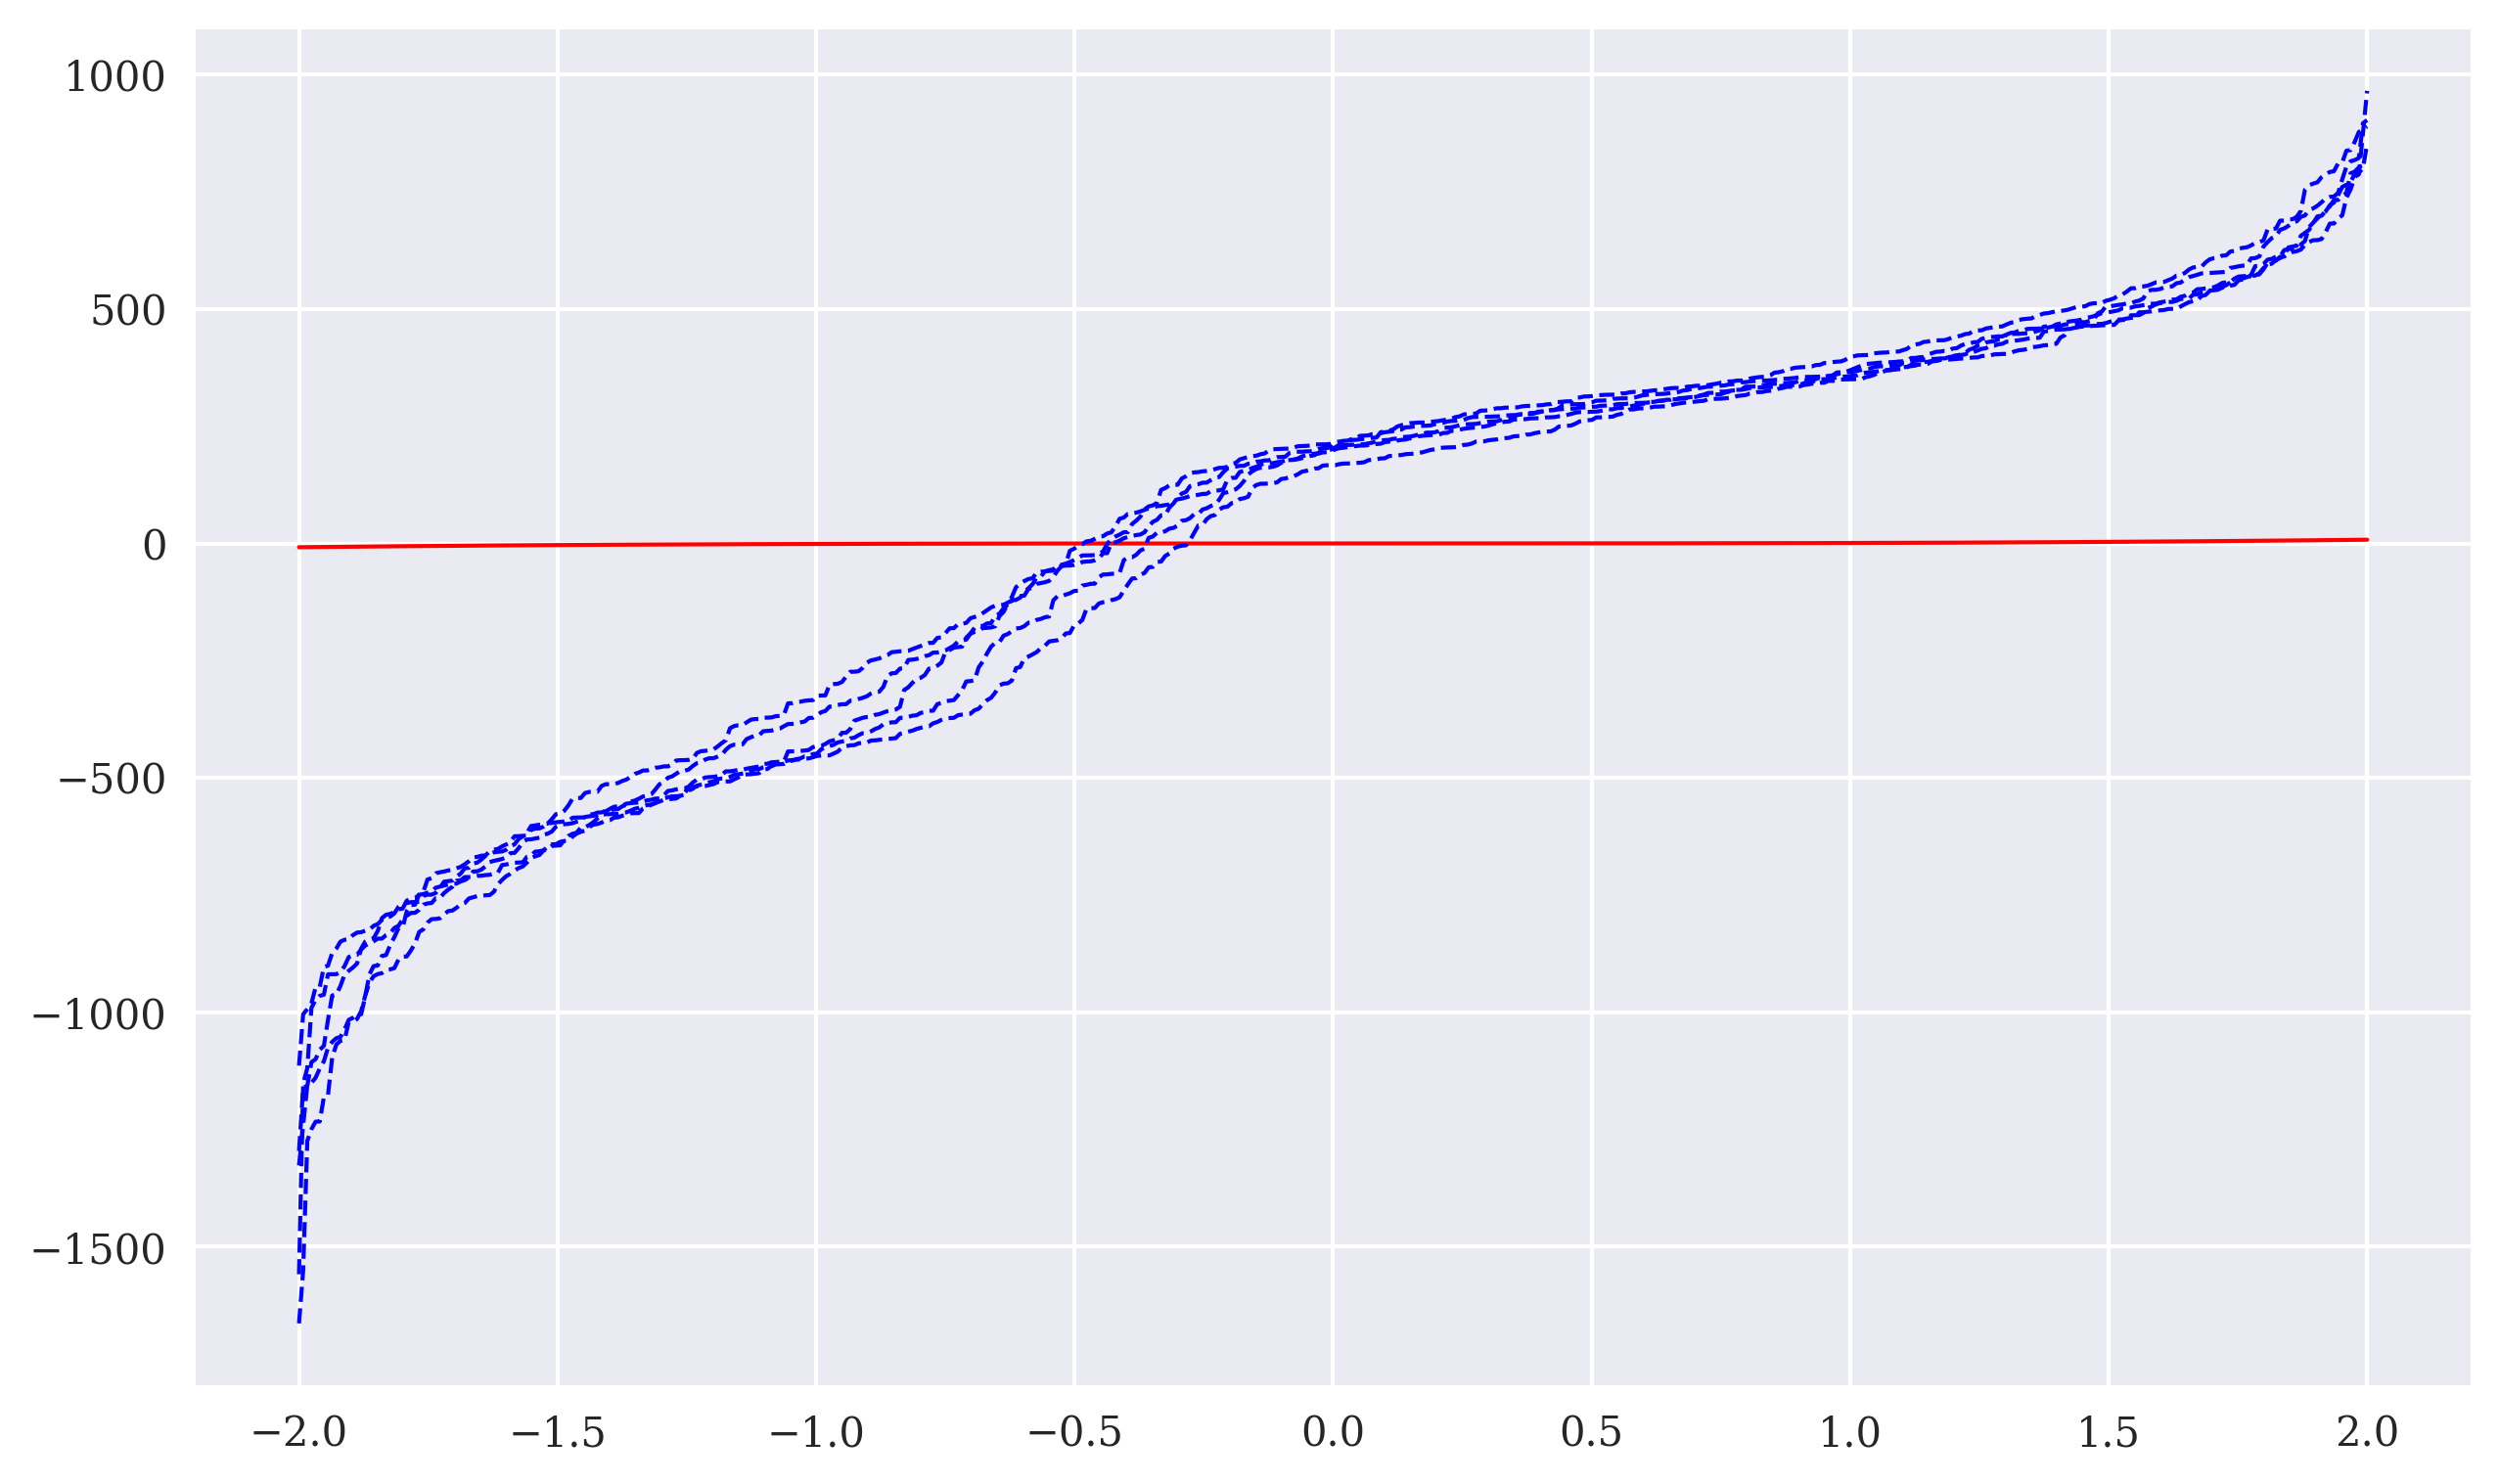

In [27]:
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False, figsize=(10,6));

## Financial Example

In [29]:
# url = 'https://certificate.tpq.io/findata.csv'
url = 'https://certificate.tpq.io/rl4finance.csv'

In [30]:
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()  # <1>

In [31]:
rets = raw['GLD'].iloc[-1000:]  # <2>
rets = np.log((rets / rets.shift(1)).dropna())  # <3>
rets = rets.values  # <4>

In [32]:
scaler = StandardScaler()  # <5>

In [33]:
rets_ = scaler.fit_transform(rets.reshape(-1, 1))  # <5>

In [34]:
rng = default_rng(100)
tf.random.set_seed(100)

In [35]:
generator = create_generator(hu=24)
discriminator = create_discriminator(hu=24)
gan = create_gan(generator, discriminator, lr=0.001)

In [36]:
%time rd, sd = train_models(y_=rets_, epochs=1001, batch_size=32)

/home/casper/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
Epoch: 1000
CPU times: user 6min 54s, sys: 2.08 s, total: 6min 56s
Wall time: 6min 54s


In [37]:
data = pd.DataFrame({'real': rets})

In [38]:
N = 25

In [39]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))  # <1>
    synthetic_data = generator.predict(noise, verbose=False)  # <1>
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)  # <2>

In [40]:
res = data.describe().round(4)  # <3>
res.iloc[:, :10]  # <3>

,real,synth_00,synth_01,synth_02,synth_03,synth_04,synth_05,synth_06,synth_07,synth_08
count,999.0000,999.0000,999.0000,999.0000,999.0000,999.0000,999.0000,999.0000,999.0000,999.0000
mean,0.0003,0.1098,0.1099,0.1104,0.1091,0.1108,0.1087,0.1095,0.1098,0.1096
std,0.0099,0.0196,0.0209,0.0209,0.0198,0.0218,0.0198,0.0210,0.0204,0.0197
min,-0.0552,0.0946,0.0946,0.0946,0.0946,0.0946,0.0946,0.0946,0.0946,0.0946
25%,-0.0048,0.0967,0.0963,0.0964,0.0963,0.0965,0.0963,0.0964,0.0966,0.0965
50%,0.0005,0.1003,0.0995,0.1003,0.0993,0.1005,0.0992,0.0994,0.1001,0.1000
75%,0.0056,0.1159,0.1157,0.1173,0.1146,0.1176,0.1147,0.1156,0.1160,0.1154
max,0.0474,0.2105,0.2223,0.2121,0.2359,0.2559,0.2207,0.2435,0.2337,0.2228


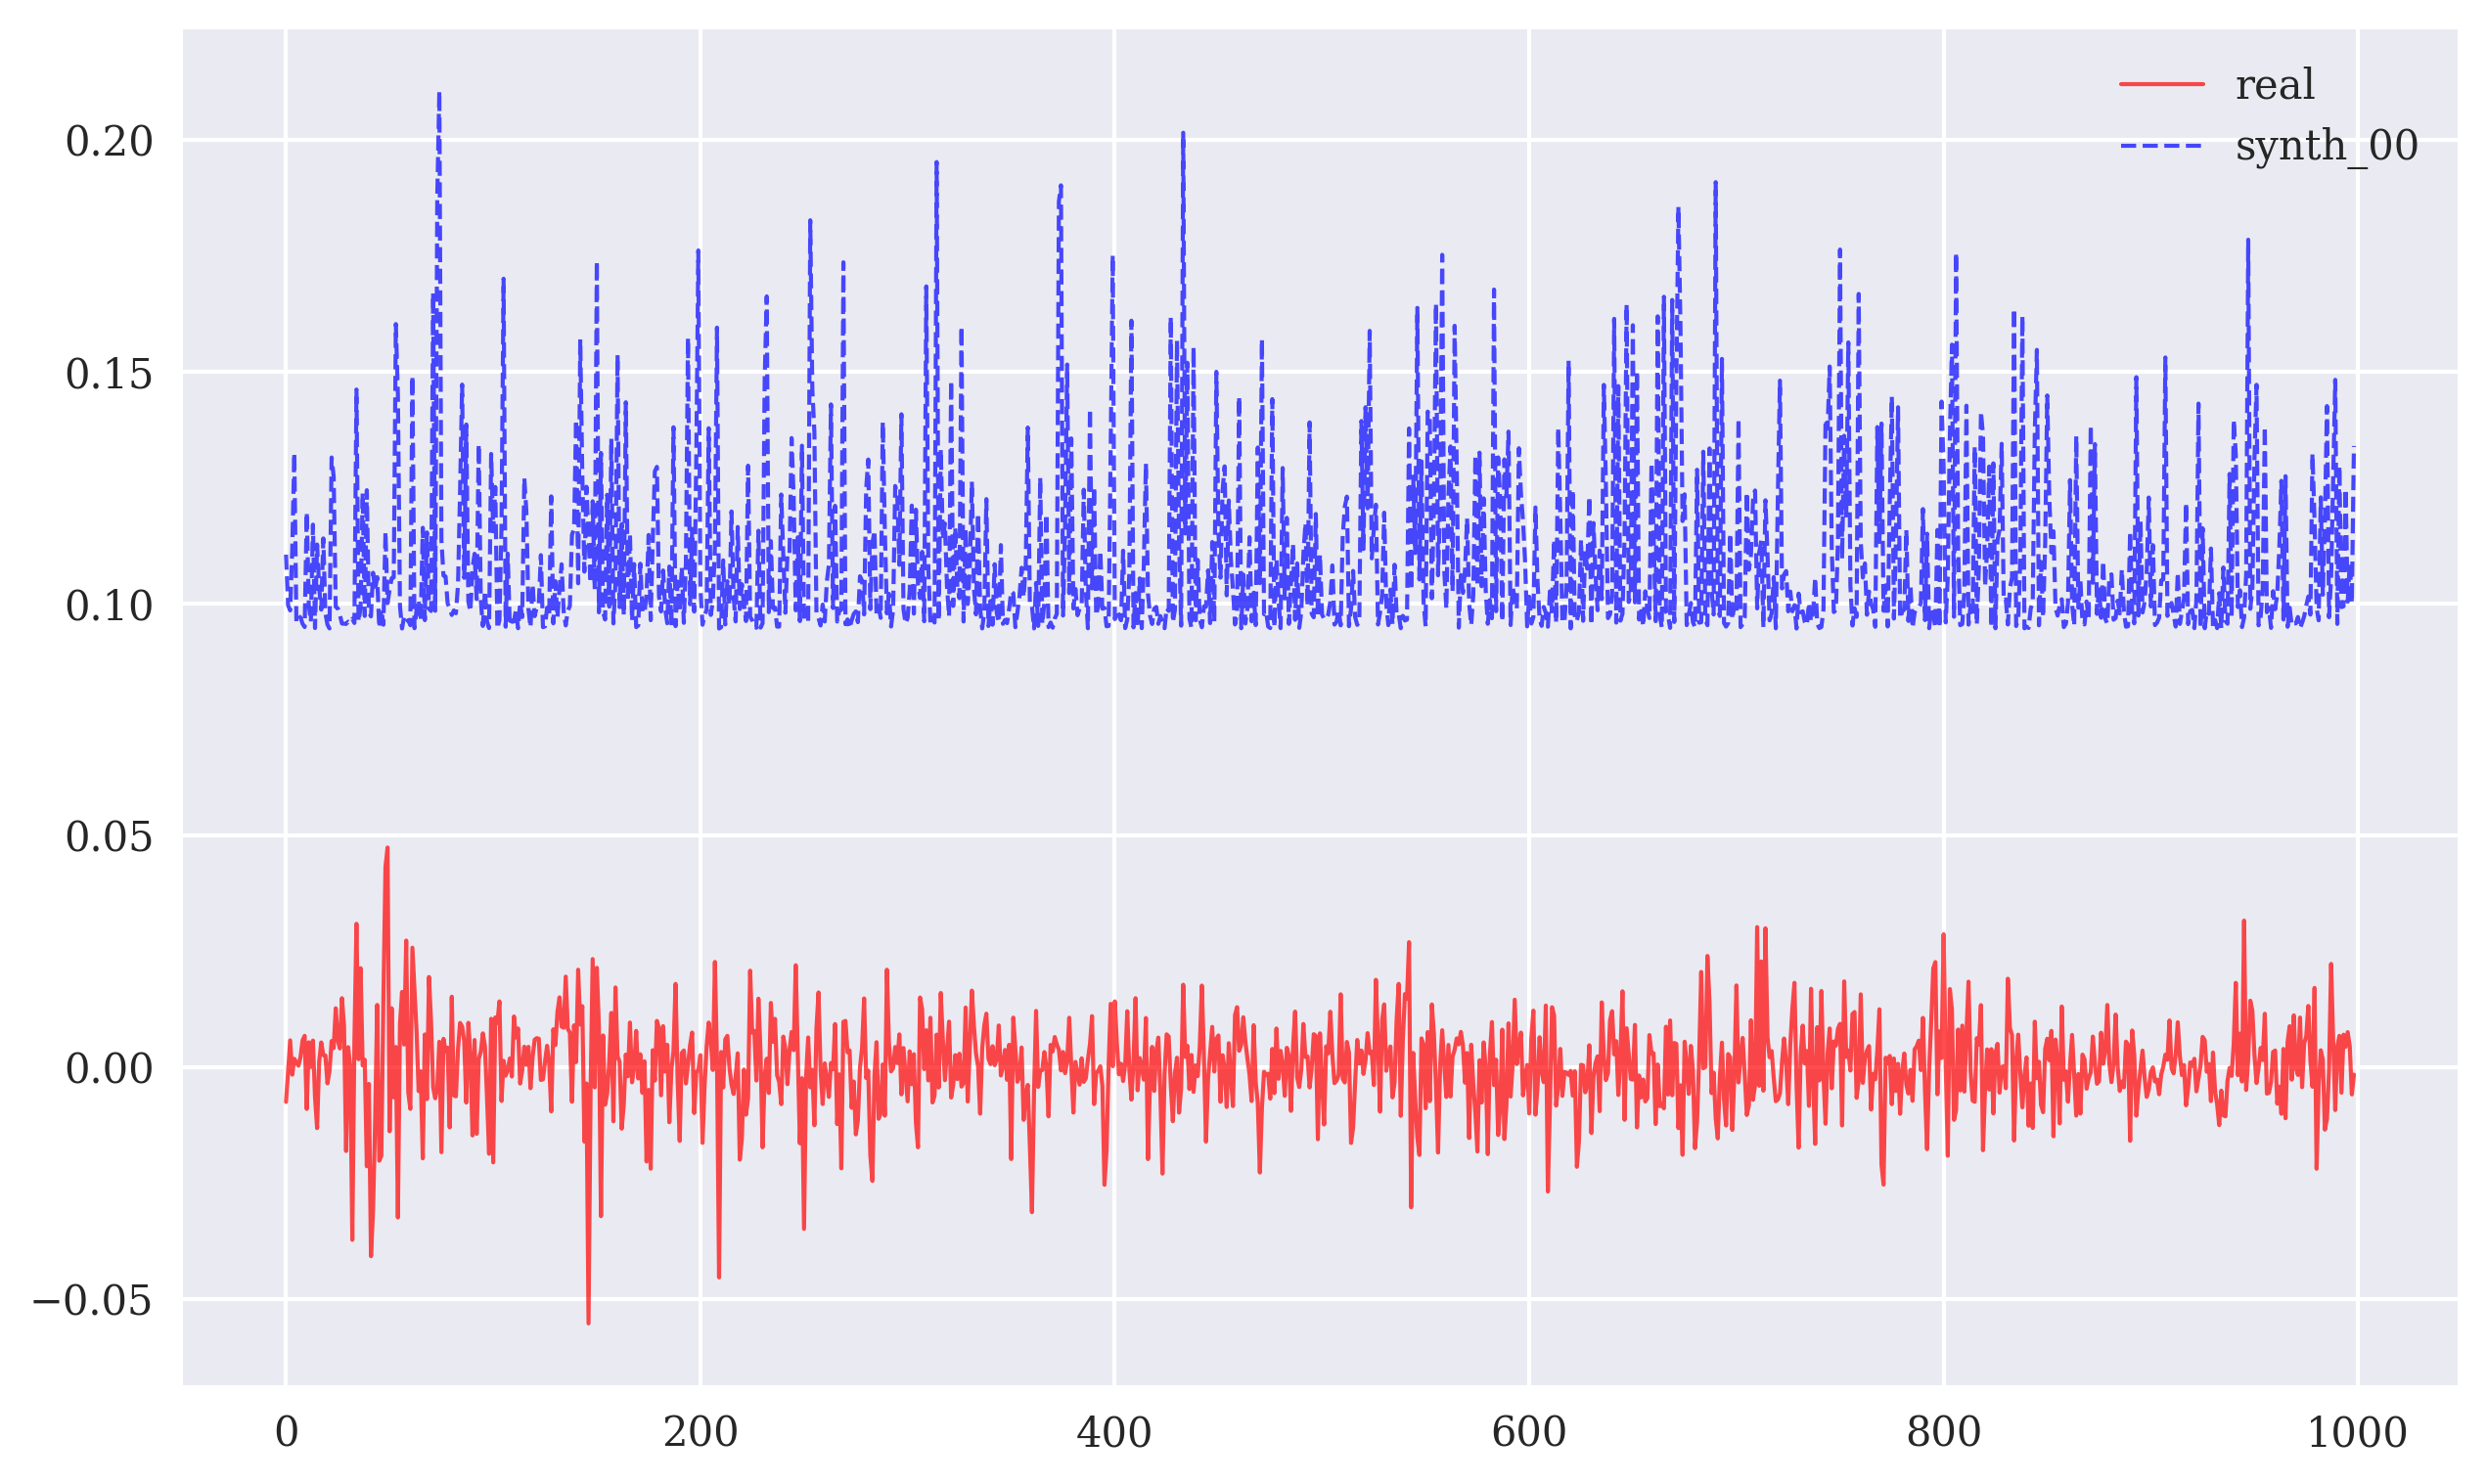

In [41]:
data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7, figsize=(10,6));

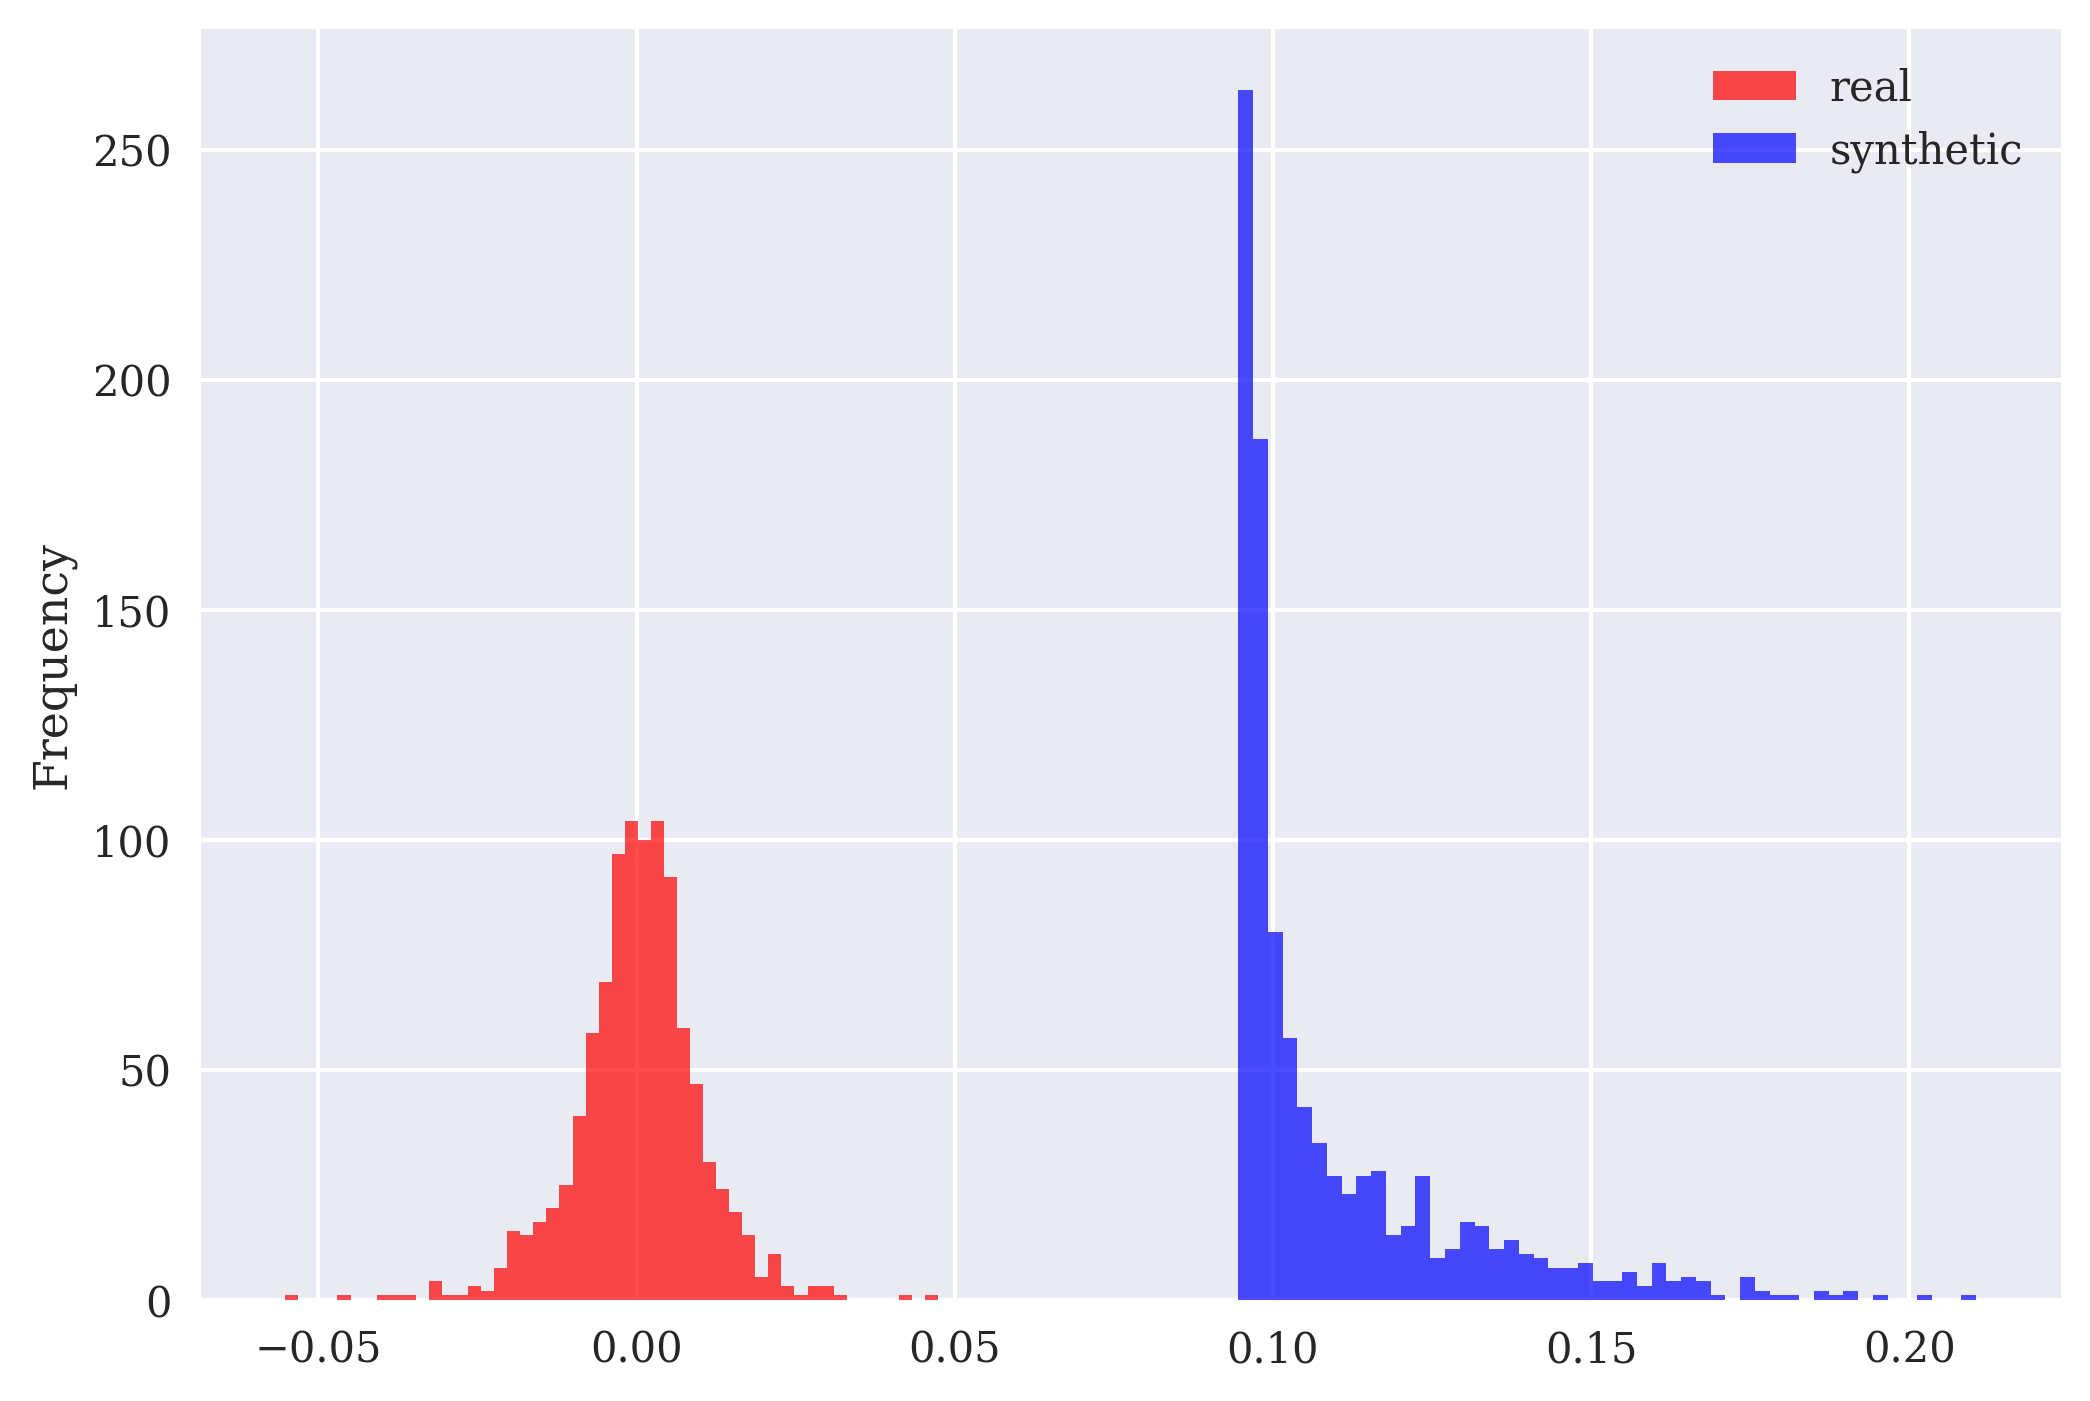

In [42]:
data['real'].plot(kind='hist', bins=50, label='real', color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7, label='synthetic', color='b', sharex=True)
plt.legend();

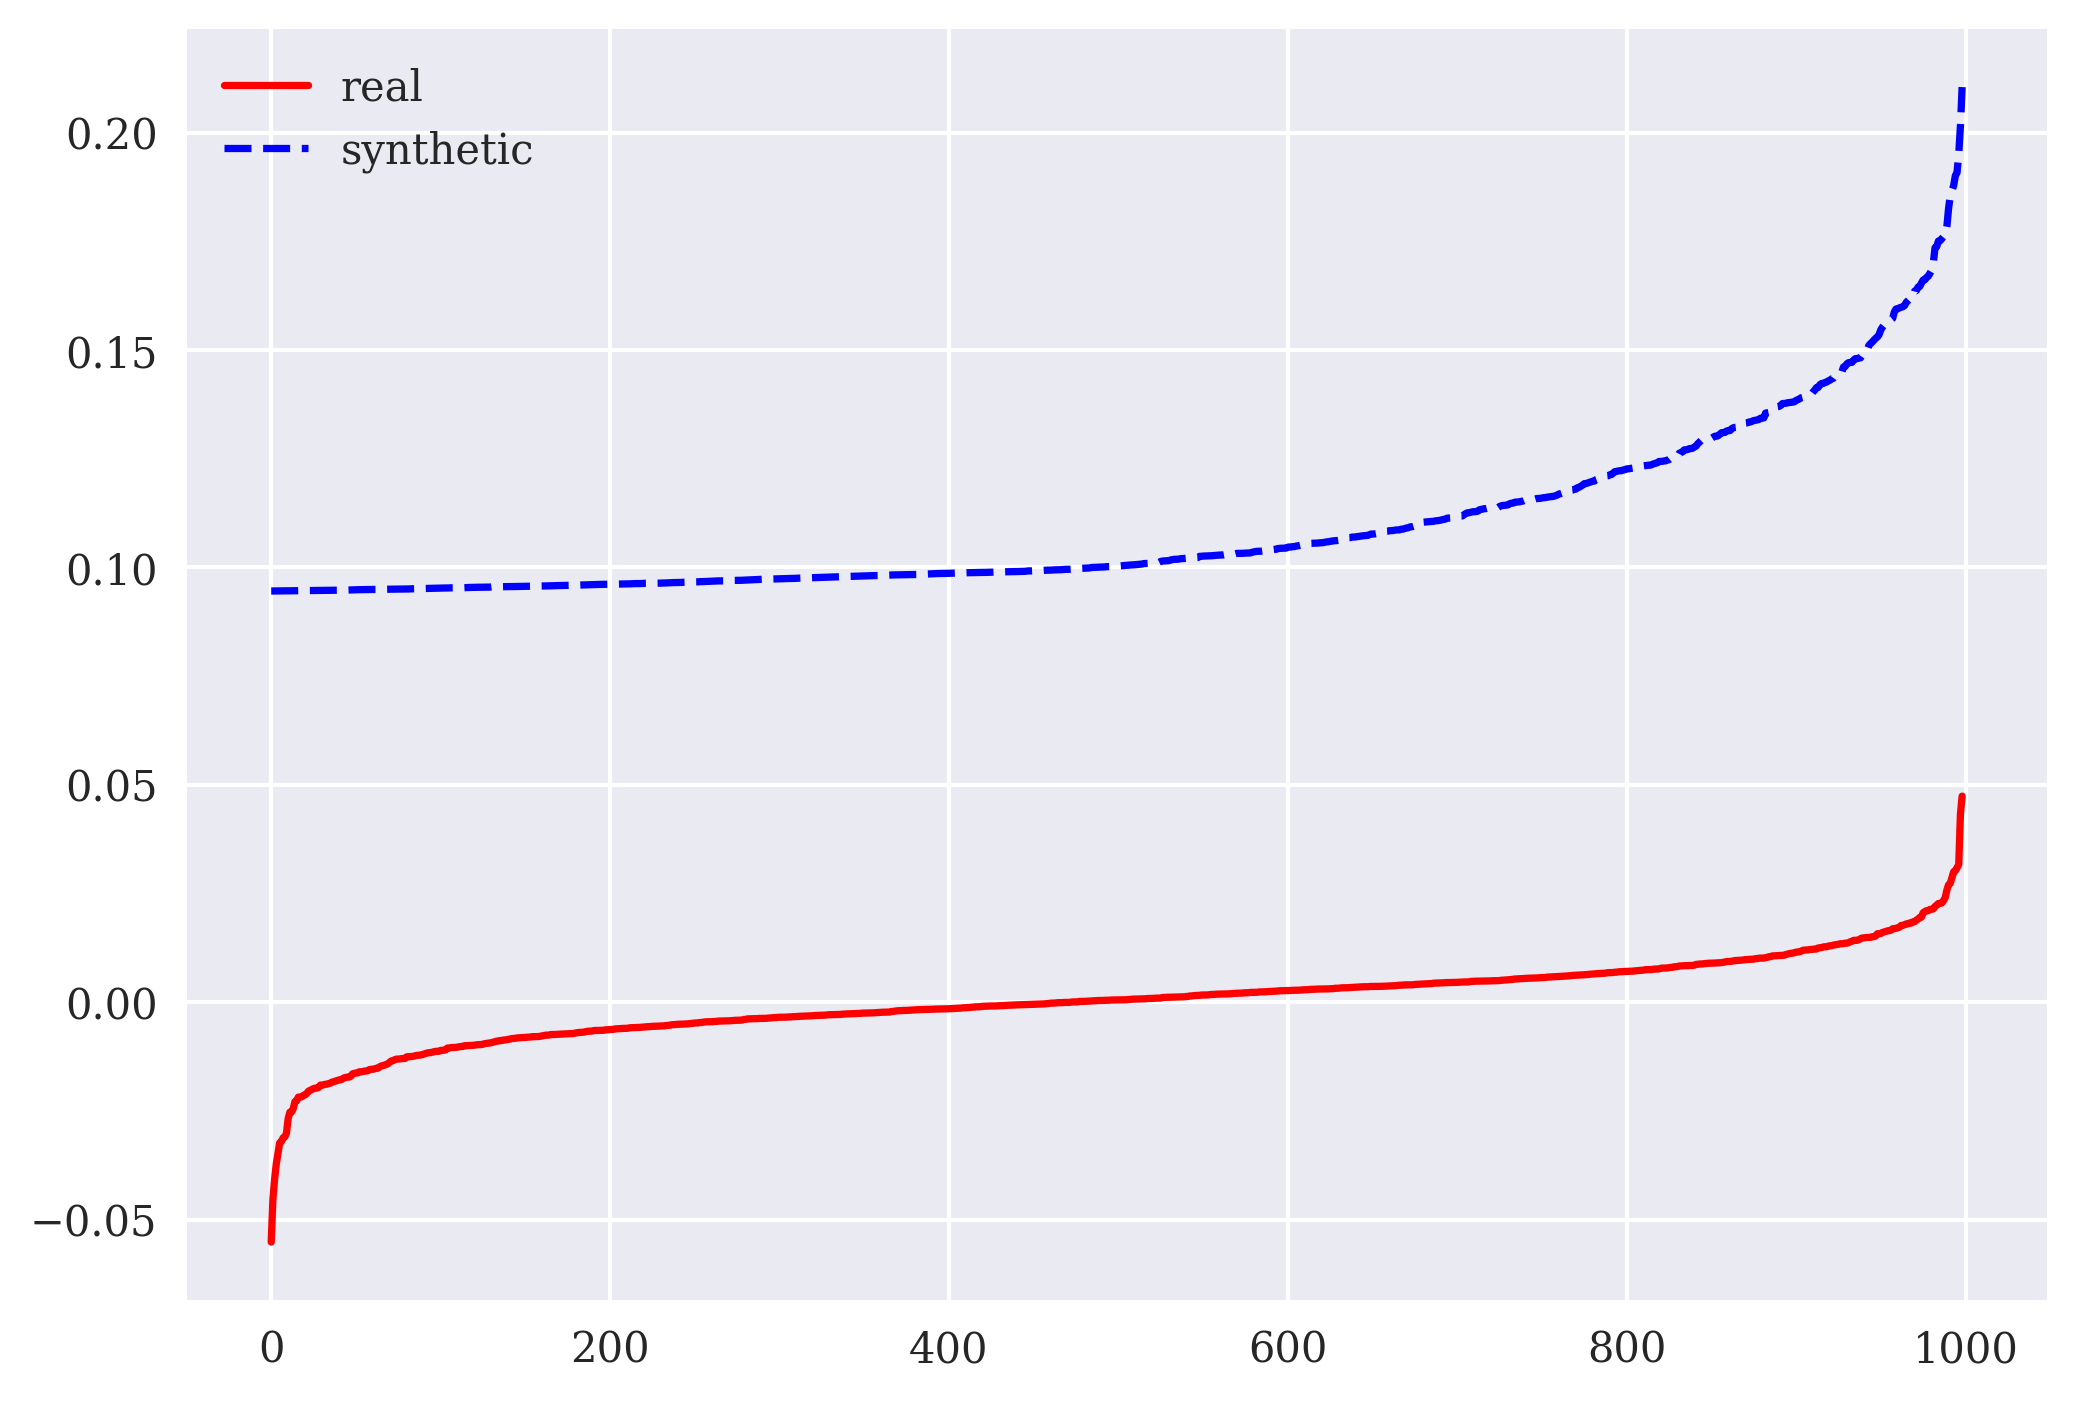

In [43]:
plt.plot(np.sort(data['real']), 'r', label='real')
plt.plot(np.sort(data['synth_00']), 'b--', label='synthetic')
plt.legend();

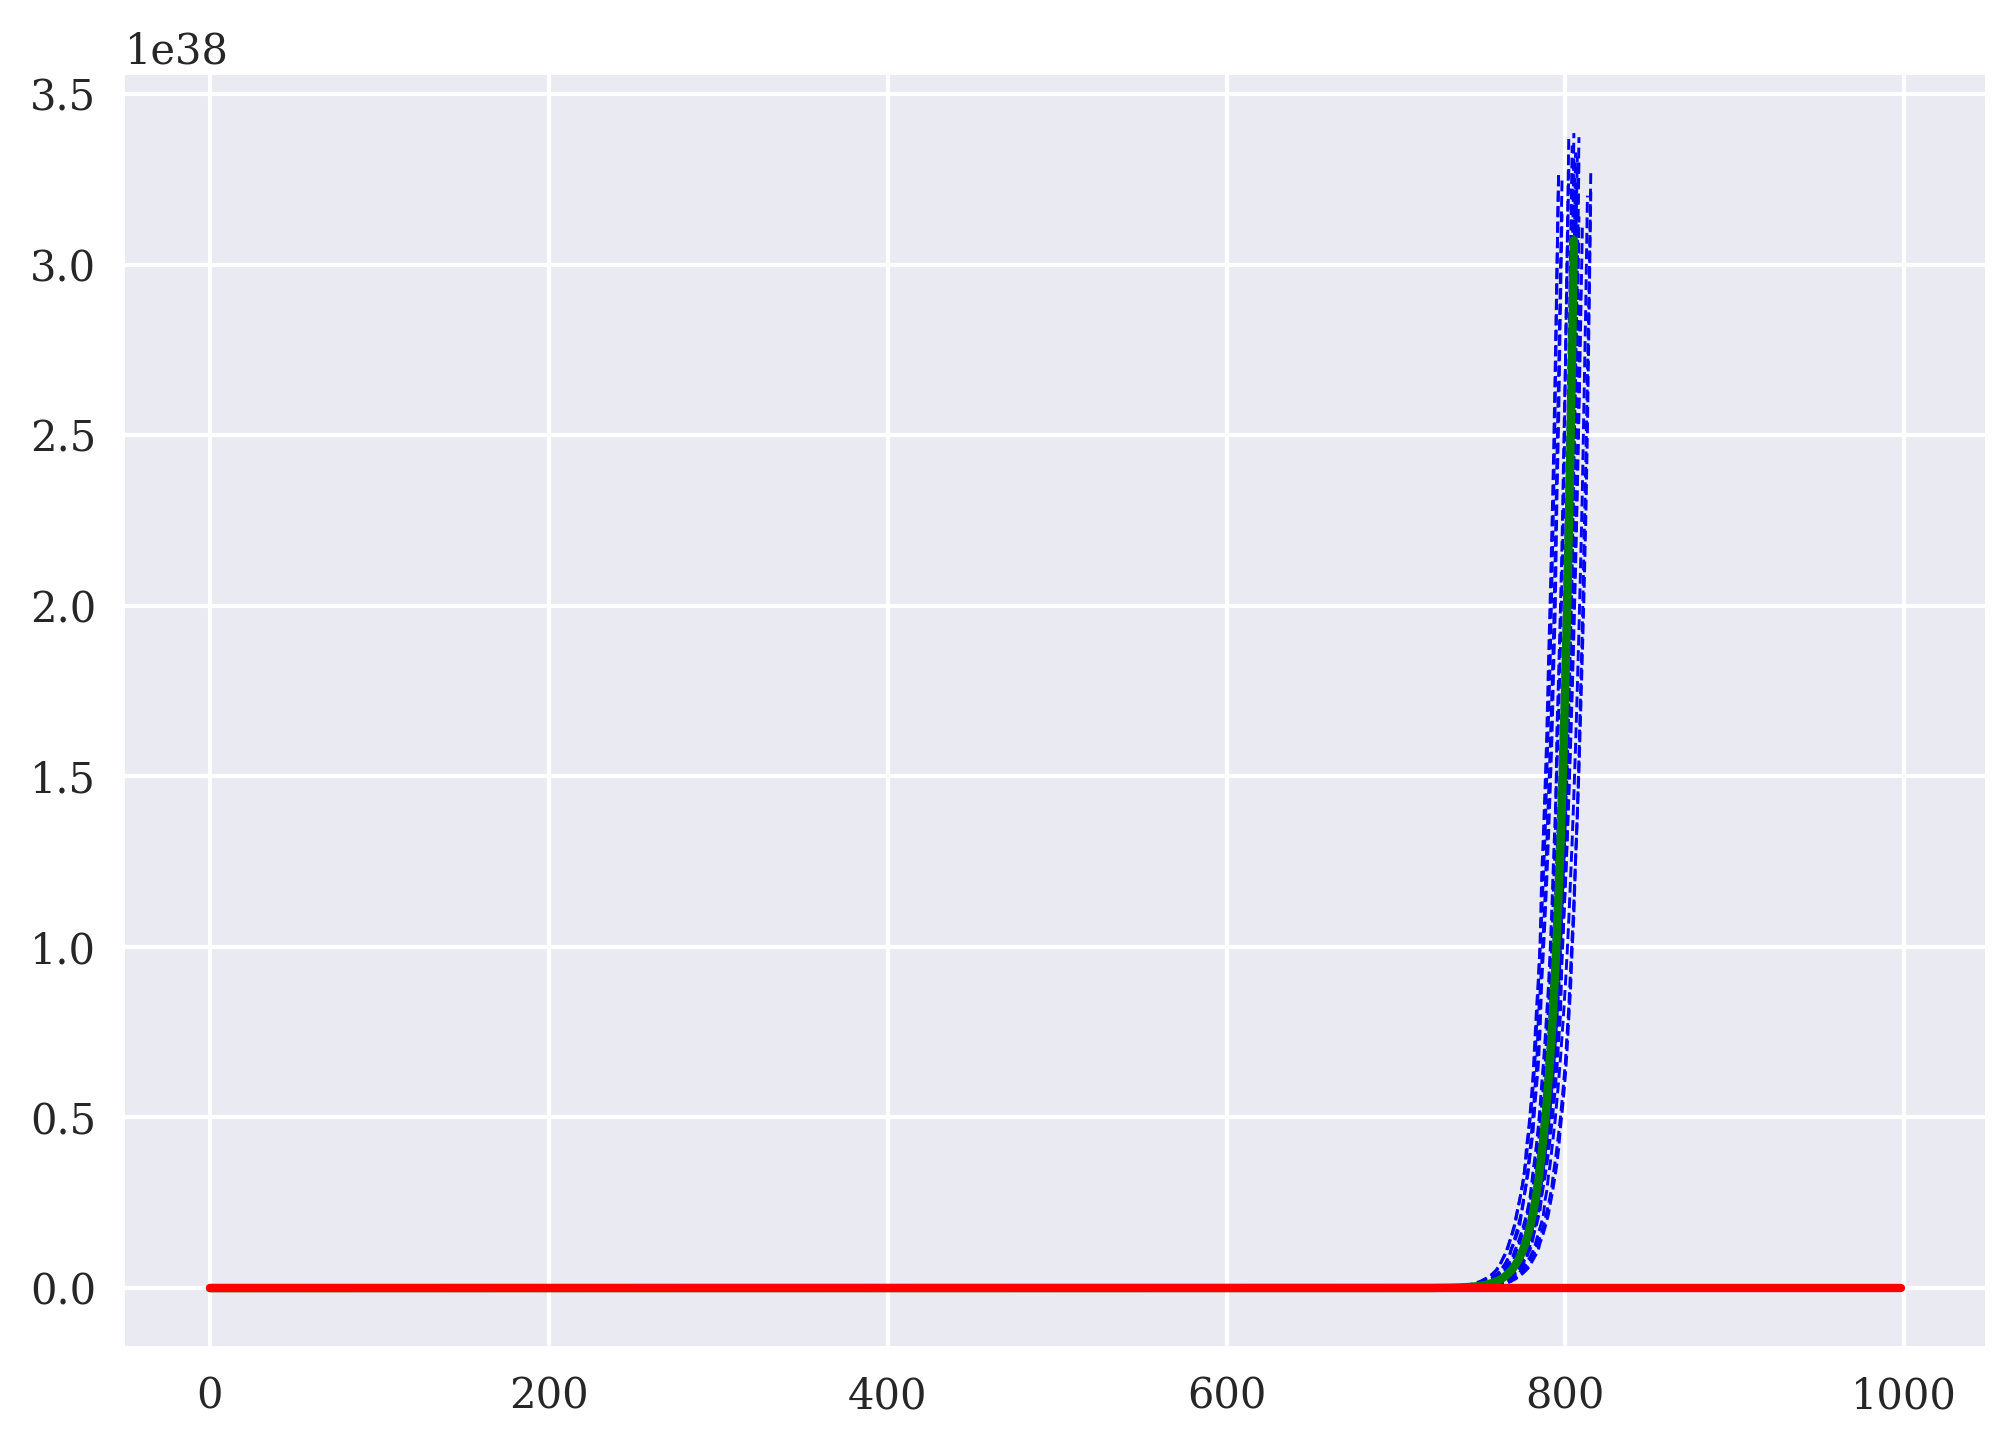

In [44]:
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

### Kolmogorow-Smirnow (KS) Test

From ChatGPT:

> The Kolmogorov-Smirnov (KS) Test is a statistical method used to determine if two datasets differ significantly or if a dataset differs significantly from a reference probability distribution. It does so by comparing the cumulative distribution functions (CDFs) of the datasets. The KS Test calculates the maximum distance (D statistic) between the CDFs of the two samples or between the sample CDF and the reference CDF. A small D value suggests the datasets are similar, while a larger D value indicates they are different. The test also provides a p-value, which helps to decide whether the observed differences are statistically significant.

In [47]:
from scipy import stats

In [48]:
pvs = list()
for i in range(N):
    pvs.append(stats.kstest(data[f'synth_{i:02d}'], data['real']).pvalue)
pvs = np.array(pvs)

In [49]:
np.sort((pvs > 0.05).astype(int))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [50]:
sum(np.sort(pvs > 0.05)) / N

0.0

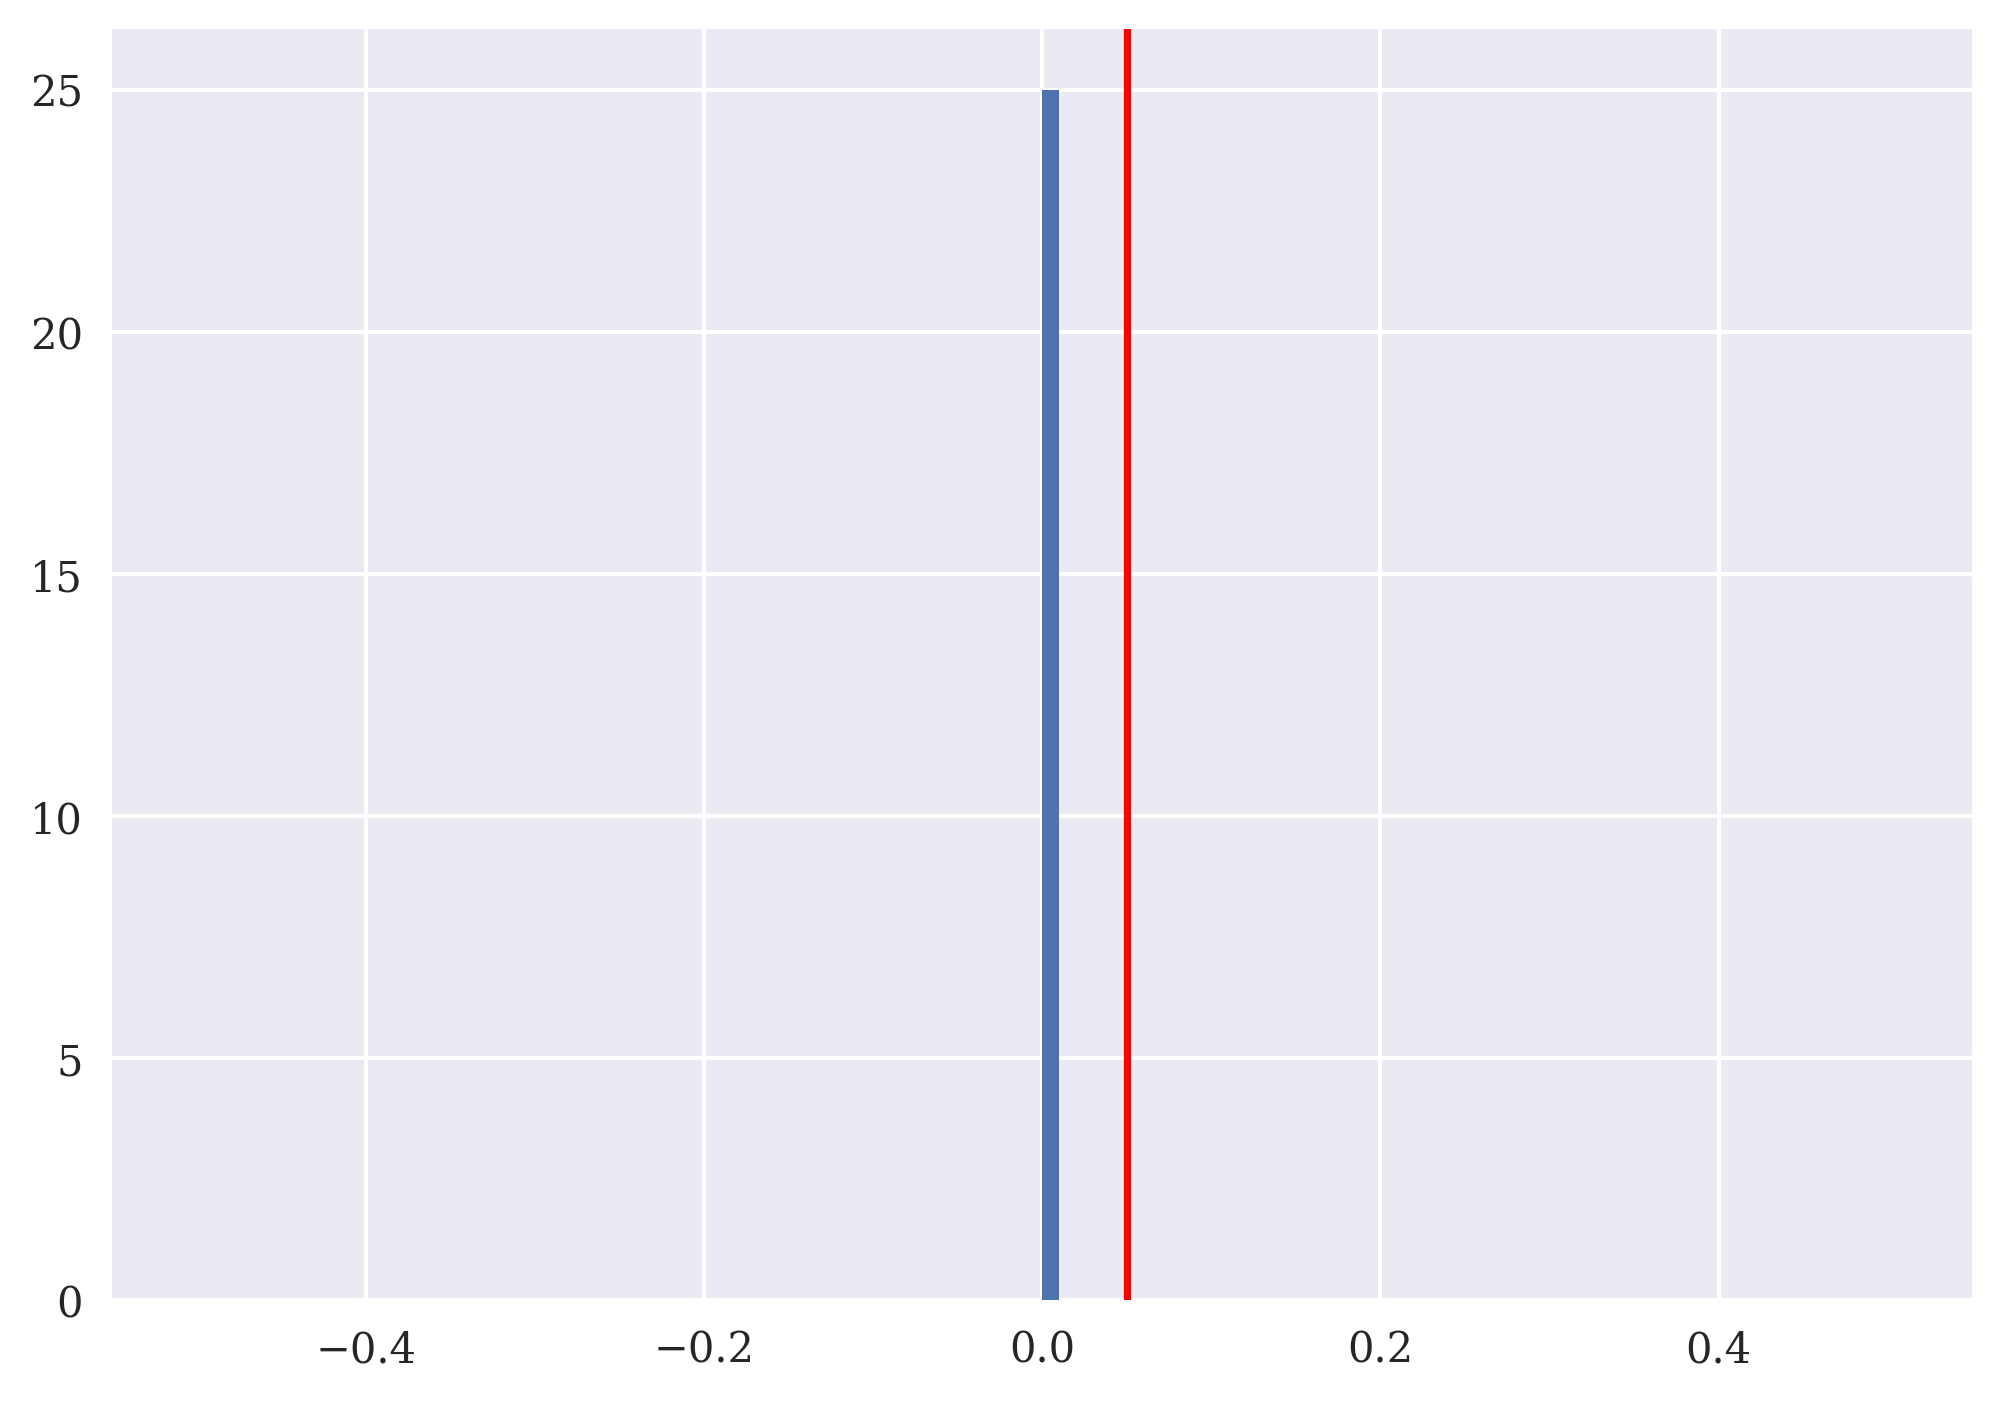

In [51]:
plt.hist(pvs, bins=100)
plt.axvline(0.05, color='r');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>